In [33]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mplhep

mplhep.style.use(["LHCbTex2"])
input_tree = uproot.open({
    "/work/cetin/LHCb/reco_tuner/data/tracking_losses_ntuple_B_def_selected.root":
    "Selected"
})
array = input_tree.arrays()

array["dSlope_xEndT"] = array["ideal_state_9410_tx"] - array[
    "ideal_state_770_tx"]
array["dSlope_xEndT_abs"] = abs(array["dSlope_xEndT"])
array["x_EndT_abs"] = abs(array["ideal_state_9410_x"])

array["z_mag_xEndT"] = (
    array["ideal_state_770_x"] - array["ideal_state_9410_x"] -
    array["ideal_state_770_tx"] * array["ideal_state_770_z"] +
    array["ideal_state_9410_tx"] *
    array["ideal_state_9410_z"]) / array["dSlope_xEndT"]

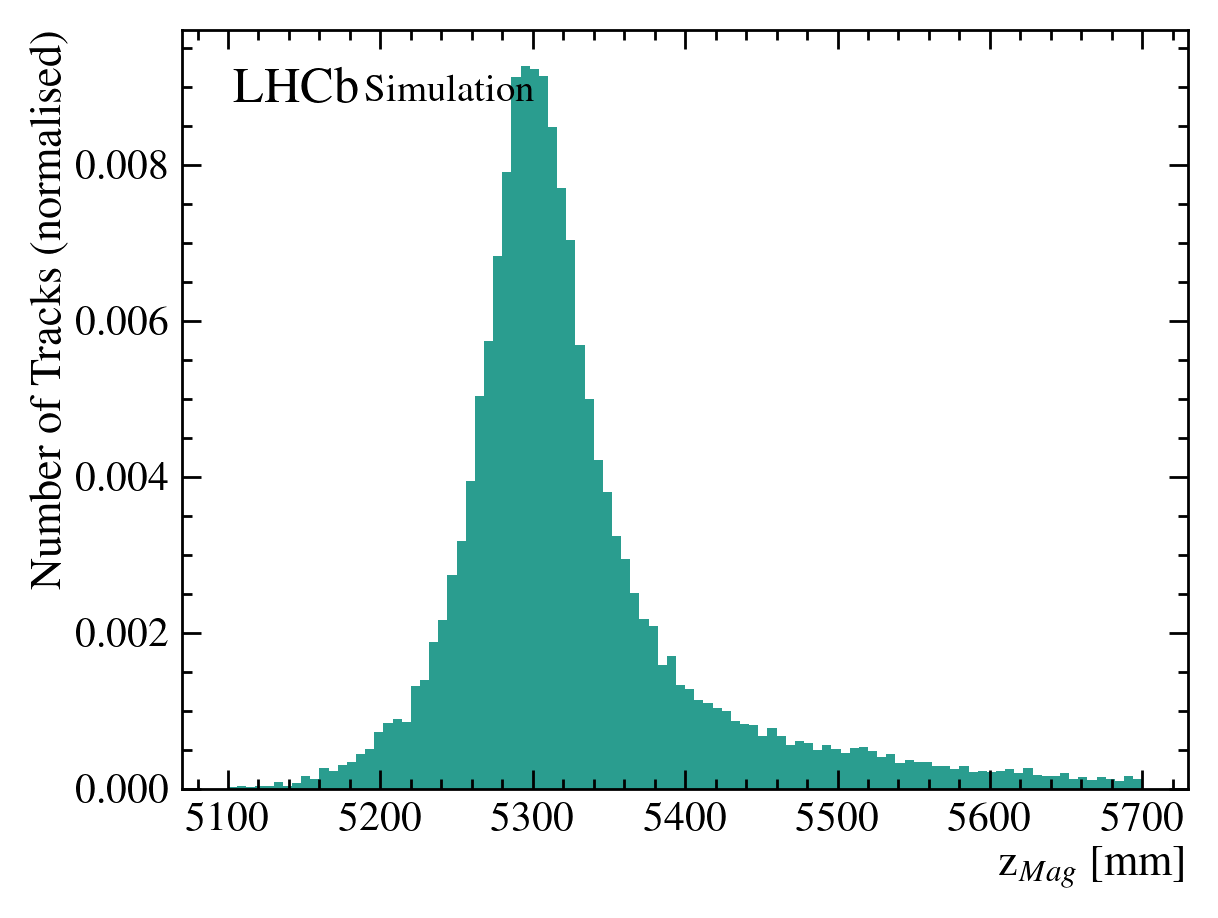

In [34]:
fig = plt.figure()
plt.hist(array["z_mag_xEndT"],
         bins=100,
         range=[5100, 5700],
         color="#2A9D8F",
         density=True)
plt.xlabel(r"z$_{Mag}$ [mm]")
plt.ylabel("Number of Tracks (normalised)")
mplhep.lhcb.text("Simulation")
plt.show()

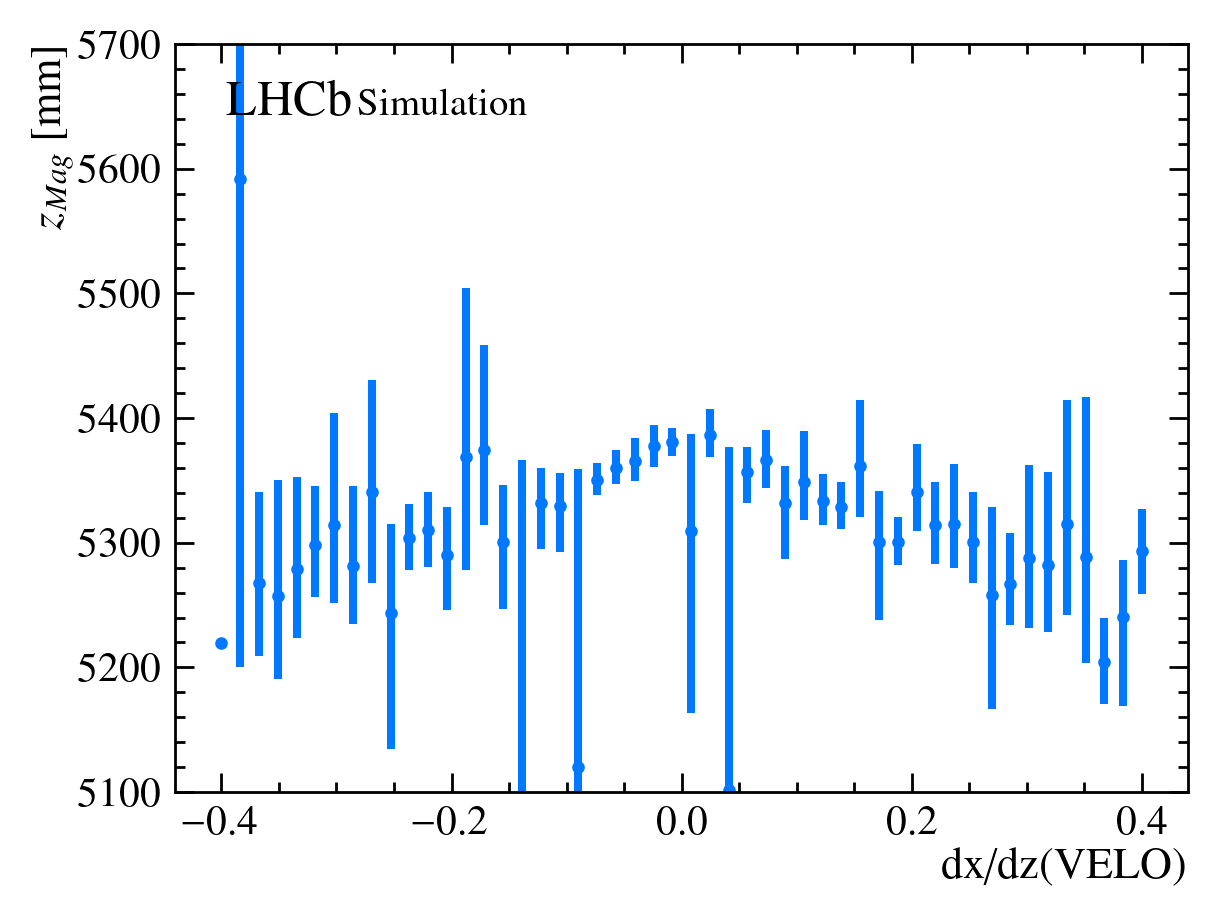

In [35]:
bins = np.linspace(-0.4, 0.4, 50)
sns.regplot(
    x=ak.to_numpy(array["ideal_state_770_tx"]),
    y=ak.to_numpy(array["z_mag_xEndT"]),
    x_bins=bins,
    fit_reg=None,
    x_estimator=np.mean,
)
plt.ylim(5100, 5700)
plt.xlabel("dx/dz(VELO)")
plt.ylabel("$z_{Mag}$ [mm]")
mplhep.lhcb.text("Simulation")
plt.show()

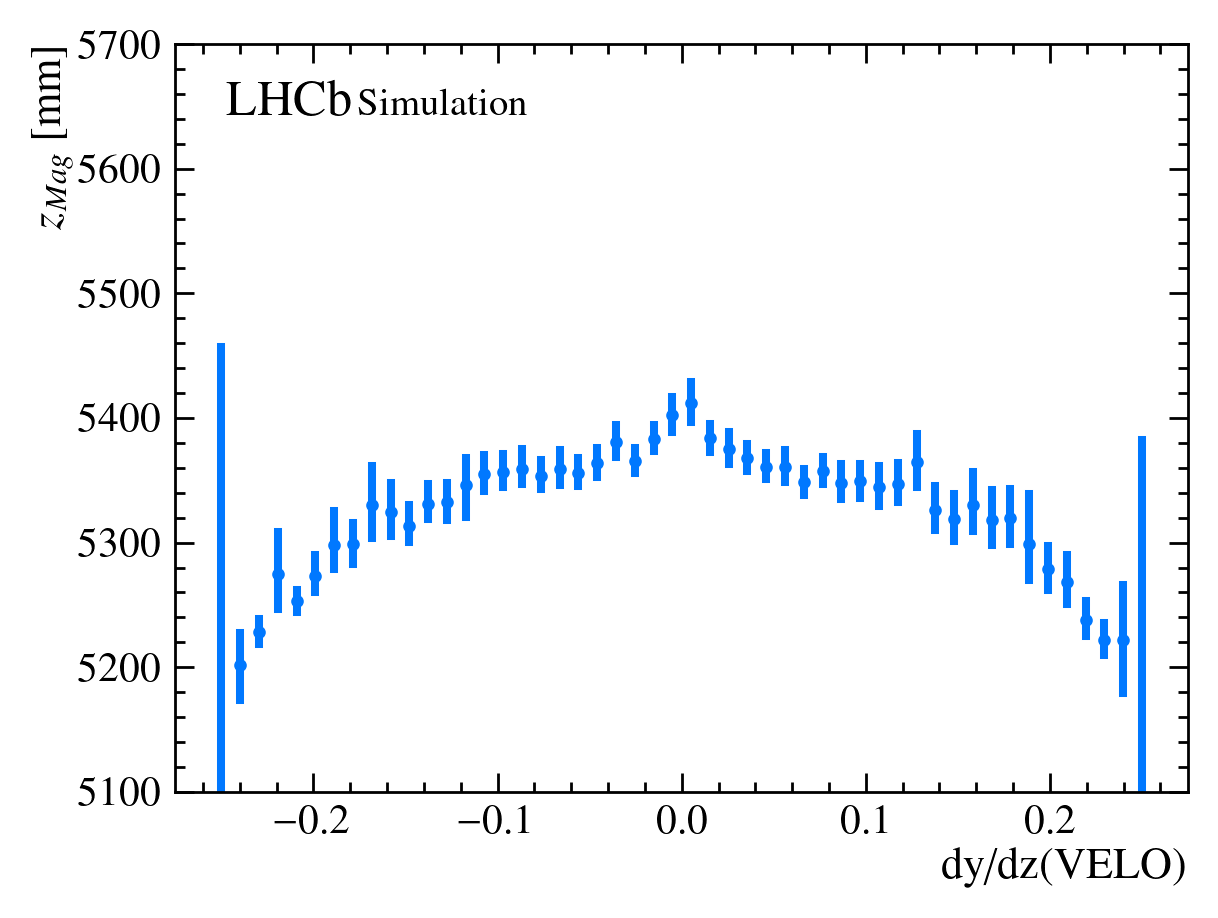

In [36]:
bins = np.linspace(-0.25, 0.25, 50)
sns.regplot(
    x=ak.to_numpy(array["ideal_state_770_ty"]),
    y=ak.to_numpy(array["z_mag_xEndT"]),
    x_bins=bins,
    fit_reg=None,
    x_estimator=np.mean,
)
plt.ylim(5100, 5700)

plt.xlabel("dy/dz(VELO)")
plt.ylabel("$z_{Mag}$ [mm]")
mplhep.lhcb.text("Simulation")
plt.show()

In [37]:
# bins = np.linspace( -300, 300, 50 )
# sns.regplot(x=ak.to_numpy(array["x"]), y=ak.to_numpy(array["z_mag_x_fringe"]), x_bins=bins, fit_reg=None, x_estimator=np.mean)

In [38]:
# bins = np.linspace( -300, 300, 50 )
# sns.regplot(x=ak.to_numpy(array["y"]), y=ak.to_numpy(array["z_mag_x_fringe"]), x_bins=bins, fit_reg=None, x_estimator=np.mean)

In [39]:
# bins = np.linspace( -1.0, 1.0, 50 )
# sns.regplot(x=ak.to_numpy(array["dSlope_out"]), y=ak.to_numpy(array["z_mag_x"]), x_bins=bins, fit_reg=None, x_estimator=np.mean)

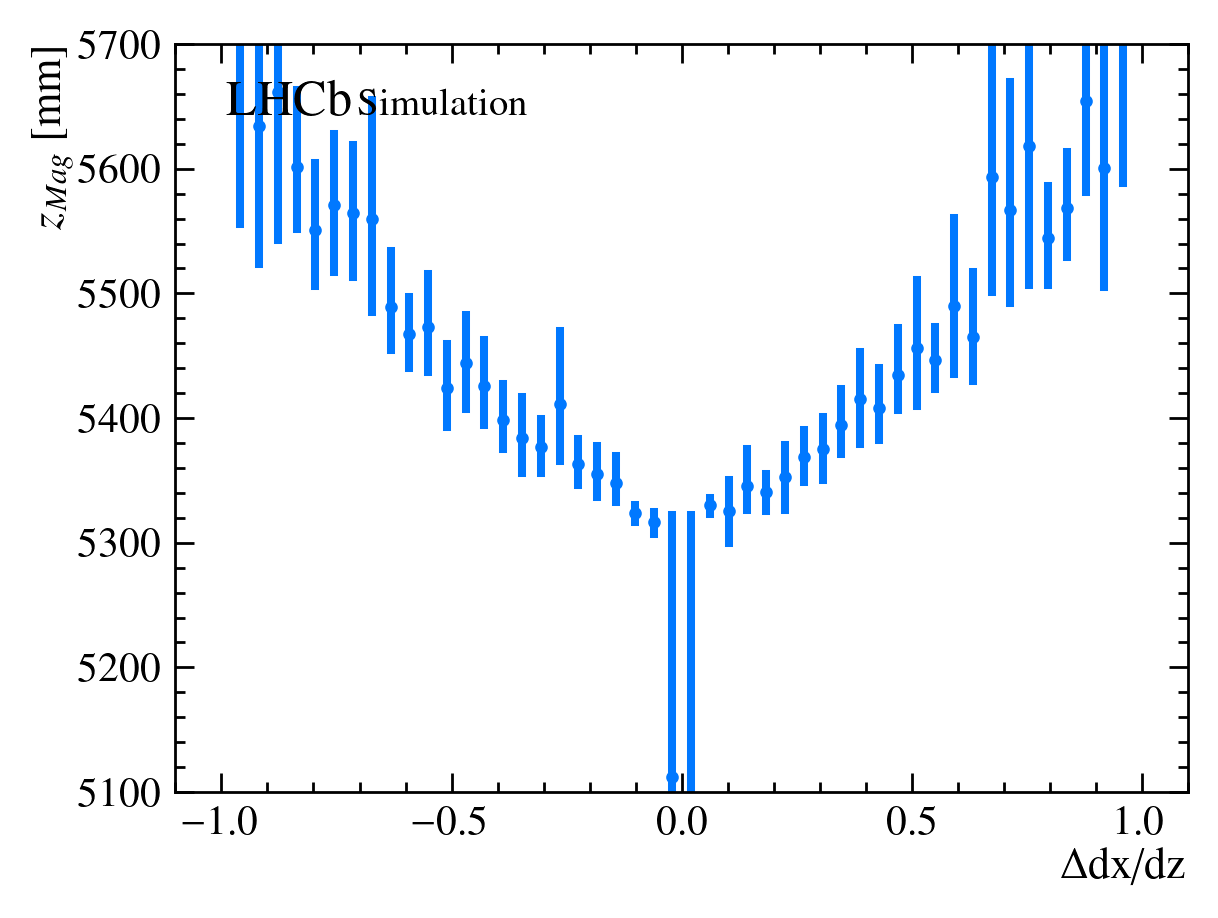

In [40]:
bins = np.linspace(-1, 1, 50)
sns.regplot(
    x=ak.to_numpy(array["dSlope_xEndT"]),
    y=ak.to_numpy(array["z_mag_xEndT"]),
    x_bins=bins,
    fit_reg=None,
    x_estimator=np.mean,
)
plt.ylim(5100, 5700)

plt.xlabel("$\Delta$dx/dz")
plt.ylabel("$z_{Mag}$ [mm]")
mplhep.lhcb.text("Simulation")
plt.show()

In [41]:
# # import matplotlib.pyplot as plt
# bins = np.linspace(-2000, 2000, 50)
# sns.regplot(
#     x=ak.to_numpy(array["x_l0"]),
#     y=ak.to_numpy(array["z_mag_x_fringe"]),
#     x_bins=50,
#     fit_reg=None,
#     x_estimator=np.mean,
#     label="T1X1",
# )
# sns.regplot(
#     x=ak.to_numpy(array["x_l4"]),
#     y=ak.to_numpy(array["z_mag_x_fringe"]),
#     x_bins=50,
#     fit_reg=None,
#     x_estimator=np.mean,
#     label="T2X1",
# )
# sns.regplot(
#     x=ak.to_numpy(array["x_l8"]),
#     y=ak.to_numpy(array["z_mag_x_fringe"]),
#     x_bins=50,
#     fit_reg=None,
#     x_estimator=np.mean,
#     label="T3X1",
# )
# plt.legend()
# plt.xlabel("x [mm]")
# plt.ylabel("$z_{Mag}$ [mm]")
# mplhep.lhcb.text("Simulation")

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

features = [
    "ideal_state_770_tx",
    "dSlope_xEndT",
    "dSlope_xEndT_abs",
    "x_EndT_abs",
]
target_feat = "z_mag_xEndT"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42
)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)

poly_features = poly.get_feature_names_out(input_features=features)
# keep = [
#     "ideal_state_770_tx^2",
#     "dSlope_xEndT^2",
#     "dSlope_xEndT_abs",
#     "x_EndT_abs",
# ]
# remove = [i for i, f in enumerate(poly_features) if f not in keep]
# X_train_model = np.delete(X_train_model, remove, axis=1)
# X_test_model = np.delete(X_test_model, remove, axis=1)
# poly_features = np.delete(poly_features, remove)
print(poly_features)

# lin_reg = LinearRegression()
lin_reg = Lasso(alpha=0.01)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))

['ideal_state_770_tx' 'dSlope_xEndT' 'dSlope_xEndT_abs' 'x_EndT_abs'
 'ideal_state_770_tx^2' 'ideal_state_770_tx dSlope_xEndT'
 'ideal_state_770_tx dSlope_xEndT_abs' 'ideal_state_770_tx x_EndT_abs'
 'dSlope_xEndT^2' 'dSlope_xEndT dSlope_xEndT_abs'
 'dSlope_xEndT x_EndT_abs' 'dSlope_xEndT_abs^2'
 'dSlope_xEndT_abs x_EndT_abs' 'x_EndT_abs^2']
intercept= 5092.708143256812
coef= {'ideal_state_770_tx': 2018.6886668629327, 'dSlope_xEndT': 389.7888543955816, 'dSlope_xEndT_abs': 1464.867616153959, 'x_EndT_abs': 0.09763035198073229, 'ideal_state_770_tx^2': -4259.173364636334, 'ideal_state_770_tx dSlope_xEndT': 887.6220587366868, 'ideal_state_770_tx dSlope_xEndT_abs': -677.4689885623392, 'ideal_state_770_tx x_EndT_abs': -0.9313147953743464, 'dSlope_xEndT^2': 179.9382929971653, 'dSlope_xEndT dSlope_xEndT_abs': 88.39317926994904, 'dSlope_xEndT x_EndT_abs': -0.19078236037510163, 'dSlope_xEndT_abs^2': 2.3666592074995823, 'dSlope_xEndT_abs x_EndT_abs': -0.48044427953929886, 'x_EndT_abs^2': 5.02886544

(exptext: Custom Text(0.0, 1, 'LHCb'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

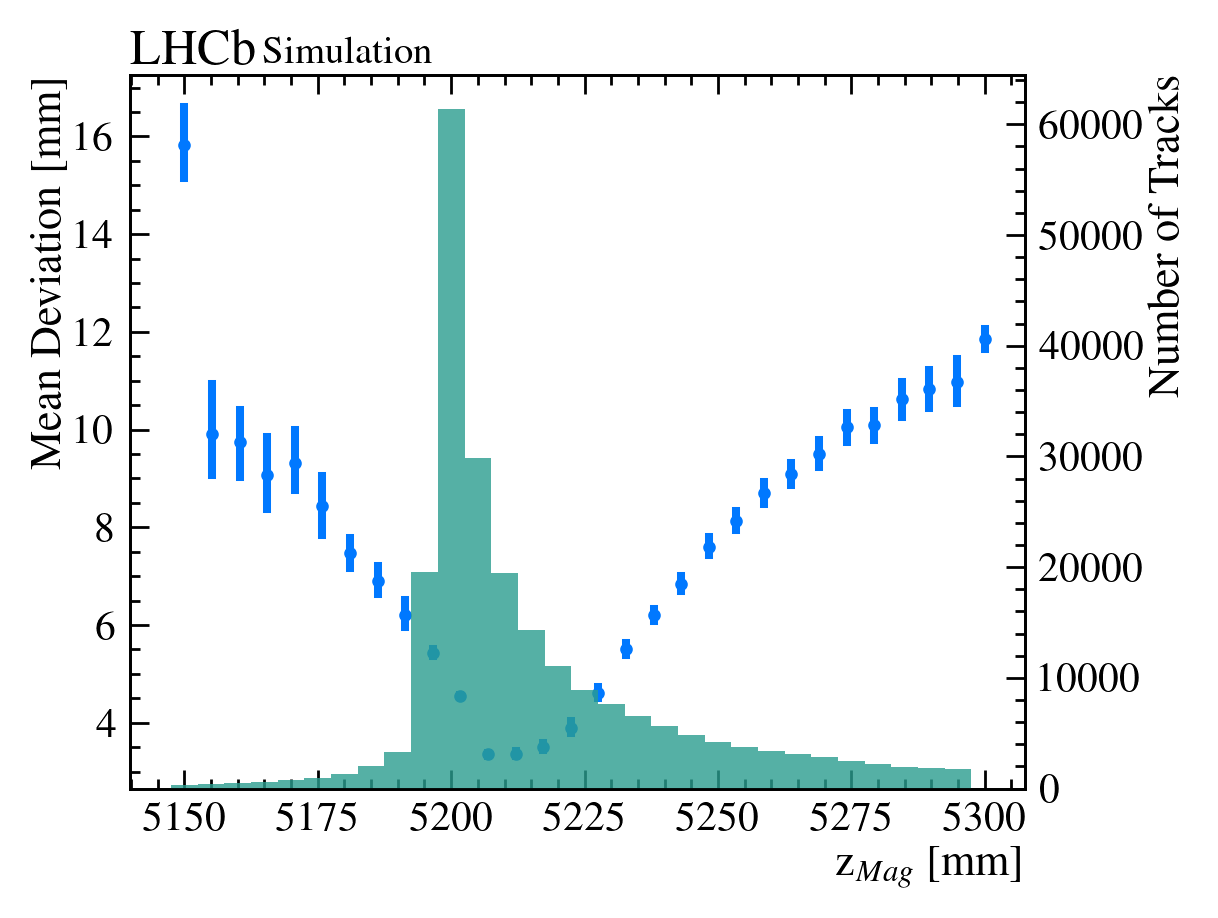

In [72]:
bins = np.linspace(5150, 5300, 30)
ax = sns.regplot(
    x=y_test,
    y=abs(y_test - y_pred_test),
    x_bins=bins,
    fit_reg=None,
    x_estimator=np.mean,
    label="bla",
)
ax2 = ax.twinx()
ax2.hist(y_test,
         bins=30,
         range=[5150, 5300],
         color="#2A9D8F",
         alpha=0.8,
         align="left")
ax.set_xlabel(r"z$_{Mag}$ [mm]")
ax.set_ylabel("Mean Deviation [mm]")
ax2.set_ylabel("Number of Tracks")
mplhep.lhcb.text("Simulation", loc=0)

In [ ]:
median_z_mag_x = np.median(array["z_mag_x_fringe"])
print(median_z_mag_x)
params_per_layer = [[] for _ in range(12)]

In [ ]:
def format_array(name, intercept, coef):
    coef = [str(c) + "f" for c in coef if c != 0.0]
    intercept = str(intercept) + "f"
    code = f"constexpr std::array {name}"
    code += "{" + ", ".join([intercept] + list(coef)) + "};"
    return code

In [ ]:
array["x_diff_straight_l0"] = (array["x_l0"] - array["x"] - array["tx"] *
                               (array["z_l0"] - array["z"]))
array["x_l0_rel"] = array["x_l0"] / 3000
features = [
    "tx",
    "ty",
    # "x_l0_rel",
    "x_diff_straight_l0",
]
target_feat = "z_mag_x_fringe"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)
poly_features = poly.get_feature_names_out(input_features=features)
keep = [
    # "tx",
    # "ty",
    # "x_l0_rel",
    "tx^2",
    # "tx x_l0_rel",
    "tx x_diff_straight_l0",
    "ty^2",
    # "x_l0_rel^2"
    "x_diff_straight_l0^2",
]
remove = [i for i, f in enumerate(poly_features) if f not in keep]
X_train_model = np.delete(X_train_model, remove, axis=1)
X_test_model = np.delete(X_test_model, remove, axis=1)
poly_features = np.delete(poly_features, remove)
print(poly_features)

lin_reg = LinearRegression()  # Lasso(alpha=0.004)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("zMagnetParams_l0", lin_reg.intercept_, lin_reg.coef_))
params_per_layer[0] = [lin_reg.intercept_] + list(lin_reg.coef_)

In [ ]:
array["x_l1_rel"] = array["x_l1"] / 3000
features = [
    "tx",
    "ty",
    "x_l1_rel",
]
target_feat = "z_mag_x_fringe"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)

lin_reg = Lasso(alpha=0.01)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print(
    "coef=",
    dict(
        zip(poly.get_feature_names_out(input_features=features),
            lin_reg.coef_)),
)
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("zMagnetParams_l1", lin_reg.intercept_, lin_reg.coef_))
params_per_layer[1] = [lin_reg.intercept_] + list(lin_reg.coef_)

In [ ]:
array["x_l2_rel"] = array["x_l2"] / 3000
features = [
    "tx",
    "ty",
    "x_l2_rel",
]
target_feat = "z_mag_x_fringe"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)

lin_reg = Lasso(alpha=0.01)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print(
    "coef=",
    dict(
        zip(poly.get_feature_names_out(input_features=features),
            lin_reg.coef_)),
)
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("zMagnetParams_l2", lin_reg.intercept_, lin_reg.coef_))
params_per_layer[2] = [lin_reg.intercept_] + list(lin_reg.coef_)

In [ ]:
array["x_l3_rel"] = array["x_l3"] / 3000
features = [
    "tx",
    "ty",
    "x_l3_rel",
]
target_feat = "z_mag_x_fringe"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)

lin_reg = Lasso(alpha=0.01)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print(
    "coef=",
    dict(
        zip(poly.get_feature_names_out(input_features=features),
            lin_reg.coef_)),
)
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("zMagnetParams_l3", lin_reg.intercept_, lin_reg.coef_))
params_per_layer[3] = [lin_reg.intercept_] + list(lin_reg.coef_)

In [ ]:
array["x_l4_rel"] = array["x_l4"] / 3000
features = [
    "tx",
    "ty",
    "x_l4_rel",
]
target_feat = "z_mag_x_fringe"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)

lin_reg = Lasso(alpha=0.01)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print(
    "coef=",
    dict(
        zip(poly.get_feature_names_out(input_features=features),
            lin_reg.coef_)),
)
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("zMagnetParams_l4", lin_reg.intercept_, lin_reg.coef_))
params_per_layer[4] = [lin_reg.intercept_] + list(lin_reg.coef_)

In [ ]:
array["x_l5_rel"] = array["x_l5"] / 3000
features = [
    "tx",
    "ty",
    "x_l5_rel",
]
target_feat = "z_mag_x_fringe"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)

lin_reg = Lasso(alpha=0.01)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print(
    "coef=",
    dict(
        zip(poly.get_feature_names_out(input_features=features),
            lin_reg.coef_)),
)
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("zMagnetParams_l5", lin_reg.intercept_, lin_reg.coef_))
params_per_layer[5] = [lin_reg.intercept_] + list(lin_reg.coef_)

In [ ]:
array["x_l6_rel"] = array["x_l6"] / 3000
features = [
    "tx",
    "ty",
    "x_l6_rel",
]
target_feat = "z_mag_x_fringe"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)

lin_reg = Lasso(alpha=0.01)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print(
    "coef=",
    dict(
        zip(poly.get_feature_names_out(input_features=features),
            lin_reg.coef_)),
)
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("zMagnetParams_l6", lin_reg.intercept_, lin_reg.coef_))
params_per_layer[6] = [lin_reg.intercept_] + list(lin_reg.coef_)

In [ ]:
array["x_l7_rel"] = array["x_l7"] / 3000
features = [
    "tx",
    "ty",
    "x_l7_rel",
]
target_feat = "z_mag_x_fringe"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)

lin_reg = Lasso(alpha=0.01)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print(
    "coef=",
    dict(
        zip(poly.get_feature_names_out(input_features=features),
            lin_reg.coef_)),
)
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("zMagnetParams_l7", lin_reg.intercept_, lin_reg.coef_))
params_per_layer[7] = [lin_reg.intercept_] + list(lin_reg.coef_)

In [ ]:
array["x_l8_rel"] = array["x_l8"] / 3000
features = [
    "tx",
    "ty",
    "x_l8_rel",
]
target_feat = "z_mag_x_fringe"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)

lin_reg = Lasso(alpha=0.01)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print(
    "coef=",
    dict(
        zip(poly.get_feature_names_out(input_features=features),
            lin_reg.coef_)),
)
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("zMagnetParams_l8", lin_reg.intercept_, lin_reg.coef_))
params_per_layer[8] = [lin_reg.intercept_] + list(lin_reg.coef_)

In [ ]:
array["x_l9_rel"] = array["x_l9"] / 3000
features = [
    "tx",
    "ty",
    "x_l9_rel",
]
target_feat = "z_mag_x_fringe"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)

lin_reg = Lasso(alpha=0.01)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print(
    "coef=",
    dict(
        zip(poly.get_feature_names_out(input_features=features),
            lin_reg.coef_)),
)
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("zMagnetParams_l9", lin_reg.intercept_, lin_reg.coef_))
params_per_layer[9] = [lin_reg.intercept_] + list(lin_reg.coef_)

In [ ]:
array["x_l10_rel"] = array["x_l10"] / 3000
features = [
    "tx",
    "ty",
    "x_l10_rel",
]
target_feat = "z_mag_x_fringe"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)

lin_reg = Lasso(alpha=0.01)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print(
    "coef=",
    dict(
        zip(poly.get_feature_names_out(input_features=features),
            lin_reg.coef_)),
)
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("zMagnetParams_l10", lin_reg.intercept_, lin_reg.coef_))
params_per_layer[10] = [lin_reg.intercept_] + list(lin_reg.coef_)

In [ ]:
array["x_l11_rel"] = array["x_l11"] / 3000
features = [
    "tx",
    "ty",
    "x_l11_rel",
]
target_feat = "z_mag_x_fringe"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)

lin_reg = Lasso(alpha=0.01)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print(
    "coef=",
    dict(
        zip(poly.get_feature_names_out(input_features=features),
            lin_reg.coef_)),
)
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("zMagnetParams_l11", lin_reg.intercept_, lin_reg.coef_))
params_per_layer[11] = [lin_reg.intercept_] + list(lin_reg.coef_)

In [ ]:
features = [
    "tx",
    "ty",
    "dSlope_fringe",
]
target_feat = "z_mag_x_fringe"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)

poly_features = poly.get_feature_names_out(input_features=features)
keep = [
    # "tx",
    # "ty",
    # "dSlope_fringe",
    "tx^2",
    "tx dSlope_fringe",
    "ty^2",
    "dSlope_fringe^2",
]
remove = [i for i, f in enumerate(poly_features) if f not in keep]
X_train_model = np.delete(X_train_model, remove, axis=1)
X_test_model = np.delete(X_test_model, remove, axis=1)
poly_features = np.delete(poly_features, remove)
print(poly_features)

lin_reg = LinearRegression()  # Lasso(alpha=0.01)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(format_array("zMagnetParams_dSlope", lin_reg.intercept_, lin_reg.coef_))

In [ ]:
import scipy.optimize


def parabola(x, a, b, c):
    return a * x**2 + b * x + c


params_1 = np.array([p[1] / params_per_layer[0][1] for p in params_per_layer])
x = [array[f"z_l{n}"][0] - array["z_ref"][0] for n in range(12)]
print(params_1)
print(x)
plt.plot(x, params_1, "o")

In [ ]:
params_3 = np.array([params_per_layer[0][3] / p[3] for p in params_per_layer])
x = [array[f"z_l{n}"][0] - array["z_ref"][0] for n in range(12)]
print(params_3**2)
print(x)
plt.plot(x, params_3, "o")

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

feautures = ["tx", "ty", "dSlope"]
data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(
    data,
    target,
    test_size=0.2,
    random_state=42,
)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)
lin_reg = LinearRegression()  # or Lasso if regularisation is needed
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))